In [24]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt

# Load and preprocess the data
# Load the fact tables and dimension tables as in your earlier script
complaint_fact = pd.read_csv("/kaggle/input/timely-response-prediction/complaint_fact.csv")
population_fact = pd.read_csv("/kaggle/input/timely-response-prediction/population_fact.csv")
category_dimension = pd.read_csv("/kaggle/input/timely-response-prediction/category_dimension.csv")
company_dimension = pd.read_csv("/kaggle/input/timely-response-prediction/company_dimension.csv")
date_dimension = pd.read_csv("/kaggle/input/timely-response-prediction/date_dimension.csv")
location_dimension = pd.read_csv("/kaggle/input/timely-response-prediction/location_dimension.csv")
year_dimension = pd.read_csv("/kaggle/input/timely-response-prediction/year_dimension.csv")

In [25]:
dimensions = [complaint_fact, category_dimension, company_dimension, 
              date_dimension, location_dimension, year_dimension, population_fact]
for i, dim in enumerate(dimensions):
    dimensions[i].columns = dim.columns.str.lower().str.replace(" ", "_")
complaint_fact, category_dimension, company_dimension, date_dimension, location_dimension, year_dimension, population_fact = dimensions

# Rename necessary columns for consistency
complaint_fact.rename(columns={"category_id_(complaint_fact)": "category_id"}, inplace=True)
company_dimension.rename(columns={"company_id_(company_dimension)": "company_id"}, inplace=True)
location_dimension.rename(columns={"location_id_(location_dimension)": "location_id"}, inplace=True)
year_dimension.rename(columns={"year_id_(year_dimension)": "year_id", "year_(year_dimension)": "year"}, inplace=True)
population_fact.rename(columns={"location_id_(population_fact)": "location_id"}, inplace=True)

# Merge all tables into a single dataset
data = complaint_fact.merge(category_dimension, how="left", on="category_id")
data = data.merge(company_dimension, how="left", on="company_id")
data = data.merge(date_dimension[['date_id', 'year']], how="left", left_on="date_id_sent", right_on="date_id")
data.rename(columns={"year": "year_id"}, inplace=True)
data.drop(columns=["date_id"], inplace=True)
data = data.merge(location_dimension, how="left", on="location_id")
data = data.merge(year_dimension, how="left", on="year_id")
data = data.merge(population_fact, how="left", on=["location_id", "year_id"])

In [ ]:
# Drop unnecessary columns
data = data.drop(columns=["year","year_id","category_id", "company_id", "complain_id", "date_id_received","date_id_sent", "location_id", "consumer_disputed","sub_issue","sub_product","population_id", "population_over_18_(bin)",
"employed_population", "population_over_18", "population_over_65","unemployed_population", "consumer_disputed"])  
print(data.columns)



# Convert categorical columns to numeric using one-hot encoding
categorical_columns = ["issue", "company", "state", "product"]

# Initialize a dictionary to store the encoders for potential inverse transformation later
label_encoders = {}

# Apply label encoding to each categorical column
for col in categorical_columns:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])
    label_encoders[col] = le  # Save the encoder for future use
# Check the data types and preview the transformed data

print(data.info())
print(data.head())



Index(['timely_response', 'issue', 'product', 'company', 'state'], dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1917617 entries, 0 to 1917616
Data columns (total 5 columns):
 #   Column           Dtype
---  ------           -----
 0   timely_response  int64
 1   issue            int64
 2   product          int64
 3   company          int64
 4   state            int64
dtypes: int64(5)
memory usage: 73.2 MB
None
   timely_response  issue  product  company  state
0                1      1        0      676     49
1                1      1        0      676     53
2                1      1        0     4421     52
3                1      1        0     2042     15
4                1      1        0     5698     30


In [27]:
# Define target and feature columns
target_column = "timely_response"
X = data.drop(columns=[target_column])  # Features
y = data[target_column]  # Target

issue      4.254536
product    5.217385
company    3.403727
state      3.535799
dtype: float64
issue      2.279502
product    2.537269
company    1.987750
state      2.034602
dtype: float64


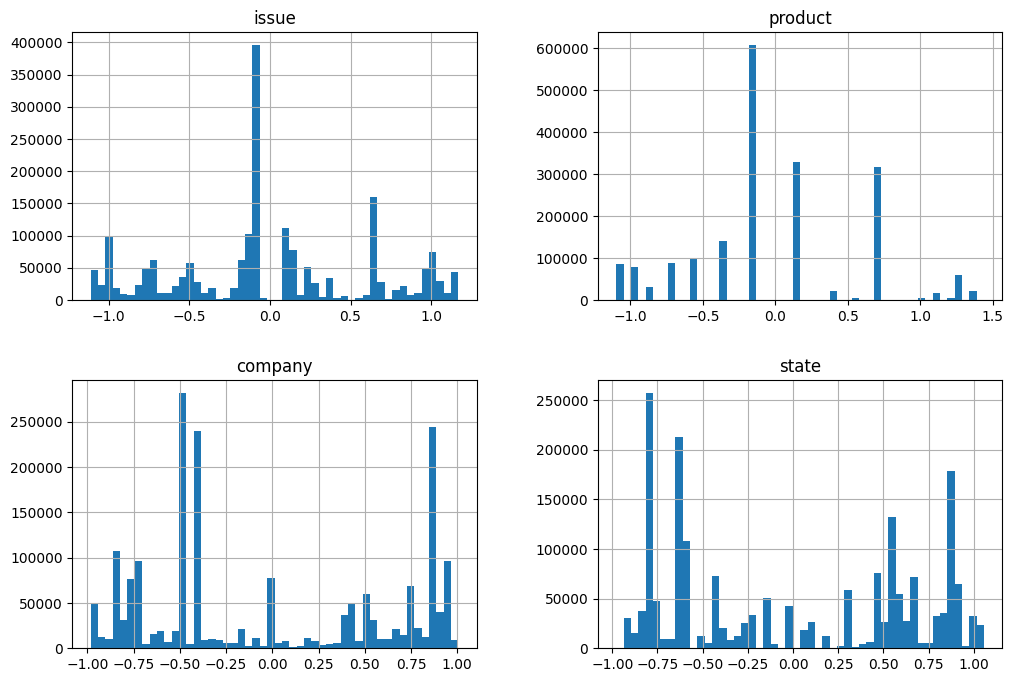

In [38]:
from sklearn.preprocessing import StandardScaler

# Initialize the scaler
scaler = StandardScaler()

# Fit and transform the features
X_standardized = scaler.fit_transform(X)

# Convert back to DataFrame for readability (optional)
X_standardized = pd.DataFrame(X_standardized, columns=X.columns)
# Calculate the range (max - min) for each column
range_per_column = X_standardized.max() - X_standardized.min()
print(range_per_column)

import numpy as np

# Apply log transformation
X_log_transformed = np.log1p(np.abs(X_standardized)) * np.sign(X_standardized)

# Convert back to DataFrame for clarity
X_log_transformed = pd.DataFrame(X_log_transformed, columns=X_standardized.columns)

range_per_column = X_log_transformed .max() - X_log_transformed .min()
print(range_per_column)

# Visualize the log-transformed data
X_log_transformed[['issue', 'product', 'company', 'state']].hist(bins=50, figsize=(12, 8))
plt.show()

In [39]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_log_transformed, y, test_size=0.2, random_state=42)

In [ ]:
model = Sequential([
    Input(shape=(X_train.shape[1],)),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')    
])
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, validation_split=0.2, epochs=10, batch_size=32, verbose=1)


Epoch 1/10
38353/38353 ━━━━━━━━━━━━━━━━━━━━ 58s 1ms/step - accuracy: 0.9775 - loss: 0.1048 - val_accuracy: 0.9795 - val_loss: 0.0930
Epoch 2/10
38353/38353 ━━━━━━━━━━━━━━━━━━━━ 56s 1ms/step - accuracy: 0.9795 - loss: 0.0926 - val_accuracy: 0.9795 - val_loss: 0.0926
Epoch 3/10
38353/38353 ━━━━━━━━━━━━━━━━━━━━ 56s 1ms/step - accuracy: 0.9795 - loss: 0.0921 - val_accuracy: 0.9795 - val_loss: 0.0916
Epoch 4/10
38353/38353 ━━━━━━━━━━━━━━━━━━━━ 56s 1ms/step - accuracy: 0.9796 - loss: 0.0914 - val_accuracy: 0.9795 - val_loss: 0.0913
Epoch 5/10
38353/38353 ━━━━━━━━━━━━━━━━━━━━ 56s 1ms/step - accuracy: 0.9793 - loss: 0.0918 - val_accuracy: 0.9795 - val_loss: 0.0910
Epoch 6/10
38353/38353 ━━━━━━━━━━━━━━━━━━━━ 56s 1ms/step - accuracy: 0.9797 - loss: 0.0903 - val_accuracy: 0.9795 - val_loss: 0.0910
Epoch 7/10
38353/38353 ━━━━━━━━━━━━━━━━━━━━ 56s 1ms/step - accuracy: 0.9794 - loss: 0.0910 - val_accuracy: 0.9795 - val_loss: 0.0916
Epoch 8/10
38353/38353 ━━━━━━━━━━━━━━━━━━━━ 57s 1ms/step - accuracy: 

In [42]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

11986/11986 ━━━━━━━━━━━━━━━━━━━━ 13s 1ms/step - accuracy: 0.9796 - loss: 0.0900
Test Loss: 0.08966629207134247
Test Accuracy: 0.979693591594696
